Looking at the sentiment values for every james bond movie. OH baby.

Checks overall sentiment over time in each movie holy shit great idea.

Set srt file to dataframe, analyse dataframe.


In [1]:
# import subprocess

# subprocess.run(["subliminal", "download","-l ", "en", "Dr_No.mp4"])

In [2]:
import re 
import os
import sys
import glob
import time
import selenium
import numpy as np
import pandas as pd
from PIL import Image

from babelfish import *
from subliminal import *

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud, STOPWORDS


#disable chained warnings
pd.options.mode.chained_assignment = None  

In [3]:
# get bond film table
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_James_Bond_films')
# get movie titles
jb_movies = df[0][2:-2][0].values
jb_flicks = []

for j in jb_movies:
#     j = j.replace("[N]", '')
#     video = Video.fromname(f'{j}')
#     subtitle = list_subtitles([video], {Language('eng')})
#     subtitle = subtitle[video][0]
#     download_subtitles([subtitle])
#     save_subtitles(video, [subtitle], directory='Subtitles')
    pass

In [4]:
df_titles = df[0][0:1].values
df_main = pd.DataFrame(df[0][2:-2])
df_main.columns = df_titles[0]

# clean columns
df_main['Title'] = df_main.Title.apply(lambda x: x.replace('[N]', ''))
df_main.drop(df_main.index[4], inplace=True)

# Sort by decade
df_main['Decade'] = df_main['Year'].apply(lambda x: x[2]+'0')

df_main.reset_index(drop=True, inplace=True)
df_main

,Title,Year,Bond actor,Director,Box office,Budget,Salary of Bond actor,Box office,Budget,Salary of Bond actor,Decade
0,Dr. No,1962,Sean Connery,Terence Young,59.5,1.1,0.1[b],448.8,7.0,0.6,60
1,From Russia with Love,1963,Sean Connery,Terence Young,78.9,2.0,0.3,543.8,12.6,1.6,60
2,Goldfinger,1964,Sean Connery,Guy Hamilton,124.9,3.0,0.5,820.4,18.6,3.2,60
3,Thunderball,1965,Sean Connery,Terence Young,141.2,6.8,0.8,848.1,41.9,4.7,60
4,You Only Live Twice,1967,Sean Connery,Lewis Gilbert,101.0,10.3,0.8 + 25% net merchandise royalty,514.2,59.9,4.4 excluding profit participation,60
5,On Her Majesty's Secret Service,1969,George Lazenby,Peter R. Hunt,64.6,7.0,0.1,291.5,37.3,0.6,60
6,Diamonds Are Forever,1971,Sean Connery,Guy Hamilton,116.0,7.2,1.2 + 12.5% of gross (14.5) [c],442.5,34.7,5.8 excluding profit participation,70
7,Live and Let Die,1973,Roger Moore,Guy Hamilton,126.4,7.0,0.18,460.3,30.8,0.7,70
8,The Man with the Golden Gun,1974,Roger Moore,Guy Hamilton,98.5,7.0,0.24 + 2.5%,334.0,27.7,0.8 excluding profit participation,70
9,The Spy Who Loved Me,1977,Roger Moore,Lewis Gilbert,185.4,14.0,0.3 + 3.75%,533.0,45.1,0.9 excluding profit participation,70


In [5]:
# the following check and clean srt specific lines
def is_time_stamp(l):
    if l[:2].isnumeric() and l[2] == ':':
        return True
    return False

def get_start_time(line):
    time = line.split()[0]
    print(time)
    if time[:2].isnumeric() and time[2] == ':':
        print(time)


def has_letters(line):
    if re.search('[a-zA-Z]', line):
        return True
    return False


def has_no_text(line):
    l = line.strip()
    if not len(l):
        return True
    if l.isnumeric():
        return True
    if is_time_stamp(l):
        return True
    if l[0] == '(' and l[-1] == ')':
        return True
    if not has_letters(line):
        return True
    return False


def is_lowercase_letter_or_comma(letter):
    if letter.isalpha() and letter.lower() == letter:
        return True
    if letter == ',':
        return True
    return False

# removes non-text lines, combines broken lines
def clean_up(lines):
    # add 'text' to list so the dataframe has a column name
    new_lines = []
    time_stamps = []
    temp_lst = []
    for line in lines[1:]:
        if has_no_text(line):
            if line[:2].isnumeric() and line[2] == ':':
                time_stamps.append(line[:8])
                continue
            continue
        elif len(new_lines) and is_lowercase_letter_or_comma(line[0]):
            #combine with previous line
            new_lines[-1] = new_lines[-1].strip() + ' ' + line
        else:
            #append line
            new_lines.append(line)
    for text, time in zip(new_lines, time_stamps):
        temp_line = [time, text.replace('\n', '').replace('-', '')]
        temp_lst.append(temp_line)
    return temp_lst


# convert srt to txt file from directory returns dict
def srt_to_txt(srt_file, encoding):
    with open(srt_file, encoding=encoding, errors='replace') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
    new_file_name = srt_file[:-4] + '.txt'
    return new_lines

# puts .txt file into a dataframe, returns df
def to_df(text):
    df = pd.read_csv(pd.compat.StringIO("\n".join(text)), sep=";")
    #remove puncutation
    df['text'] = df['text'].str.replace('[^\w\s]', '')
    return df

va = SentimentIntensityAnalyzer()
def get_sentiment(tweet):
    """
    VADER Analysis --> returns negative, neutral, positive, compounded sentiment.
    compound = normalized, weighted composite score between -1, 1
    """
    score = va.polarity_scores(tweet)
    temp_list = [score['compound'], score['pos'], score['neu'], score['neg']]
    return temp_list[0]

In [31]:
srt_test = 'Subtitles/GoldenEye.en.srt'
encoding = 'utf-8' 
temp_srt = srt_to_txt(srt_test, encoding)[1:] #ignore first advertisement 
temp_srt

[['00:02:58', 'I beg your pardon.'],
 ['00:03:46', 'I forgot to knock.'],
 ['00:03:51', "I'm alone."],
 ['00:03:54', "Aren't we all?"],
 ['00:03:57', " You're late, 007."],
 ['00:03:59', ' I had to stop in the bathroom.'],
 ['00:04:05', 'Ready to save the world again?'],
 ['00:04:09', 'After you, 006.'],
 ['00:04:52', 'James, for England.'],
 ['00:04:54', 'For England, Alec.'],
 ['00:04:57', "It's too easy."],
 ['00:05:00', 'Half of everything is luck, James.'],
 ['00:05:03', 'And the other half?'],
 ['00:05:32', 'Fate.'],
 ['00:05:36', ' Set timers: six minutes.'],
 ['00:05:39', ' Six minutes, check.'],
 ['00:05:56', 'Fire!'],
 ['00:06:00', 'Closing time, James!'],
 ['00:06:05', 'Last call!'],
 ['00:06:10', 'Buy me a pint.'],
 ['00:06:24',
  'This is Colonel Ourumov! Come out with your hands above your heads!'],
 ['00:06:28', 'How original.'],
 ['00:06:30', 'Shut the door, Alec!'],
 ['00:06:34', "There's a draft!"],
 ['00:06:36', 'Alec?'],
 ['00:06:39', 'Move out. Throw down your weap

In [9]:
bond_srts[0] = 'Dr'

/Users/BMO/Desktop/Dairshine/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


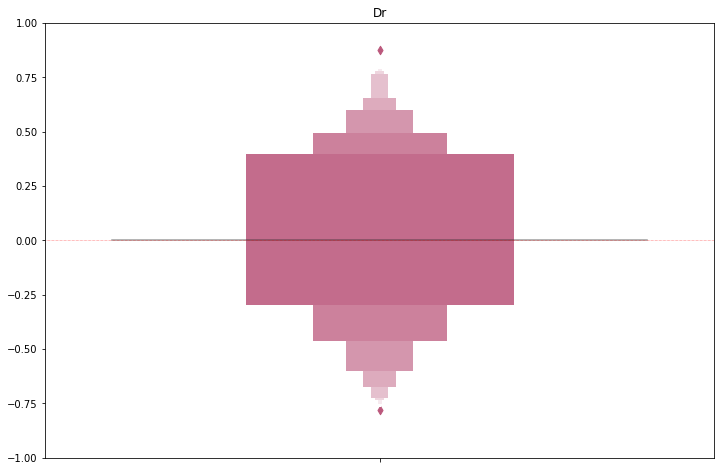

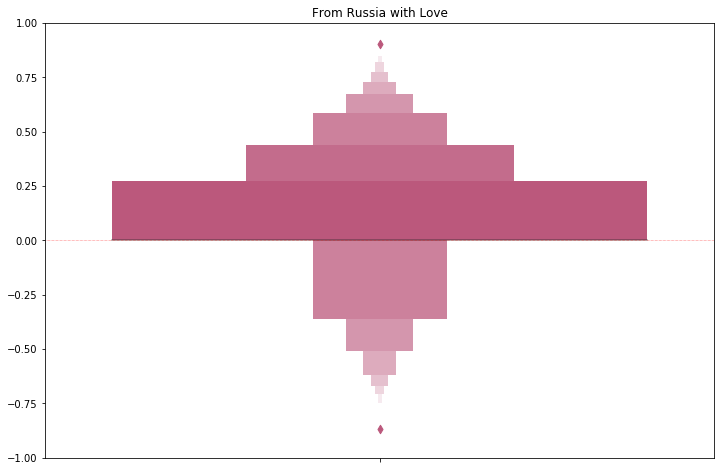

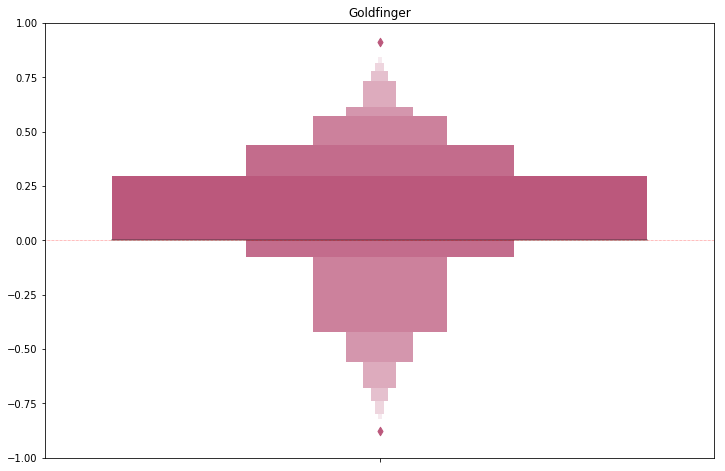

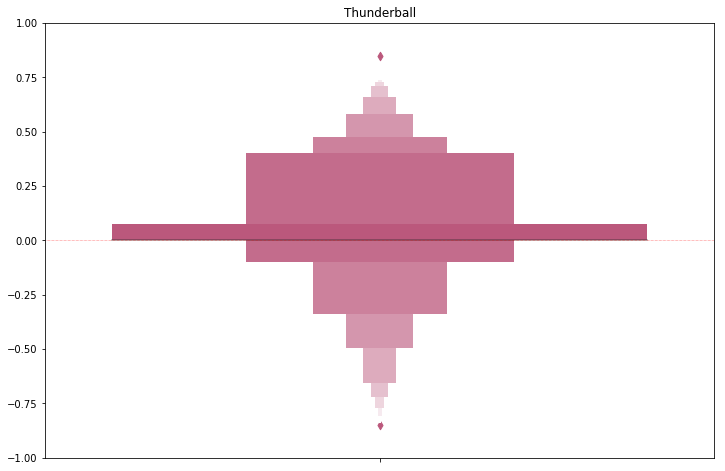

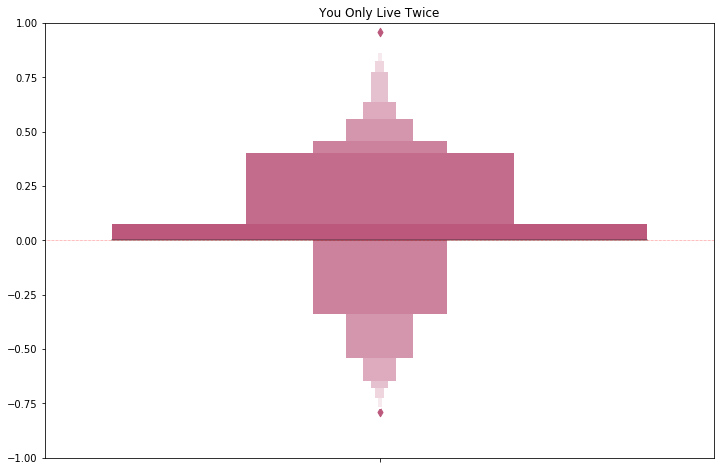

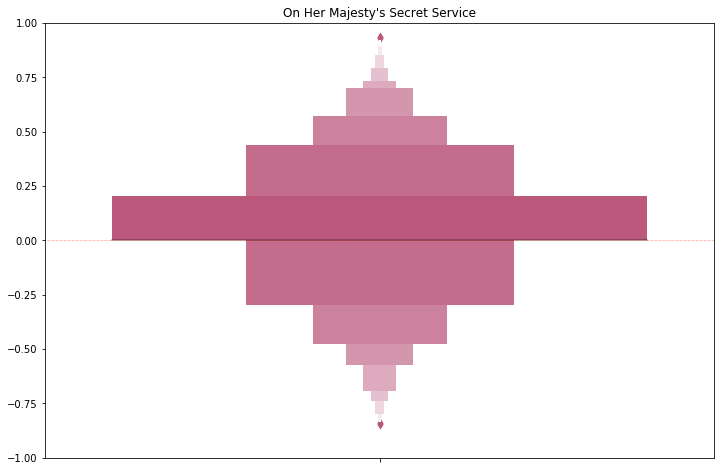

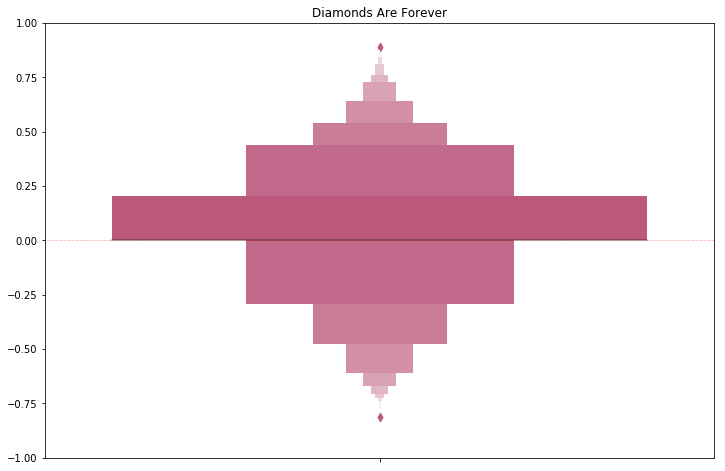

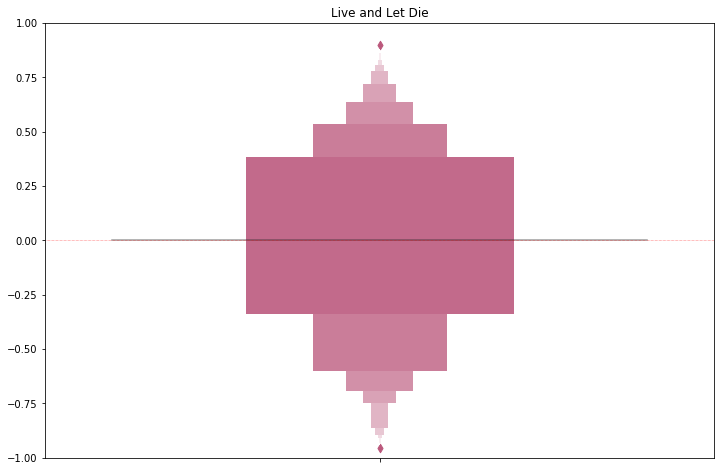

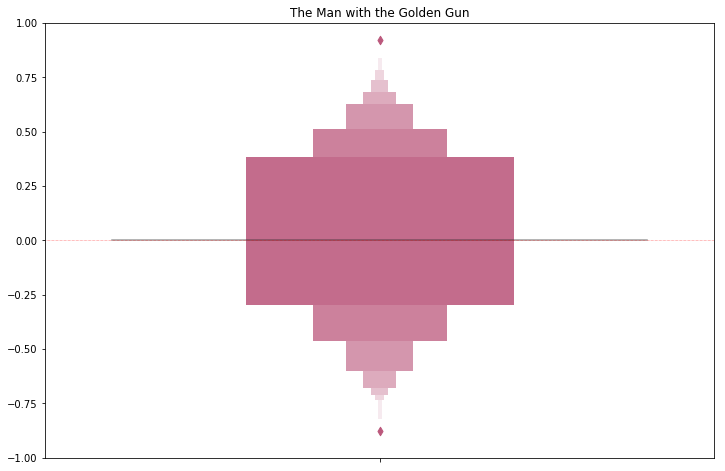

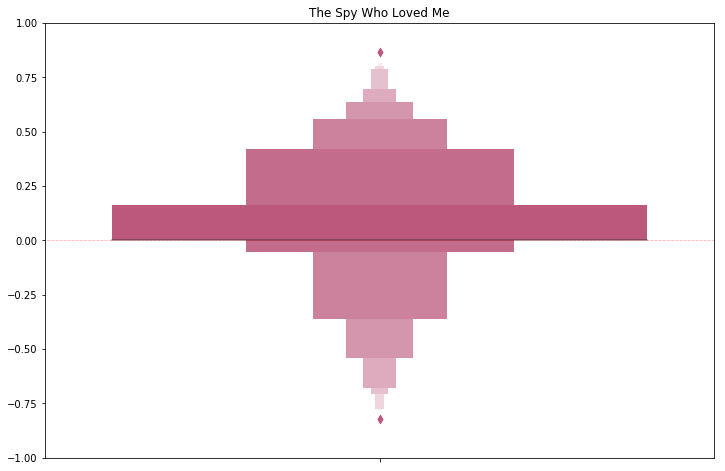

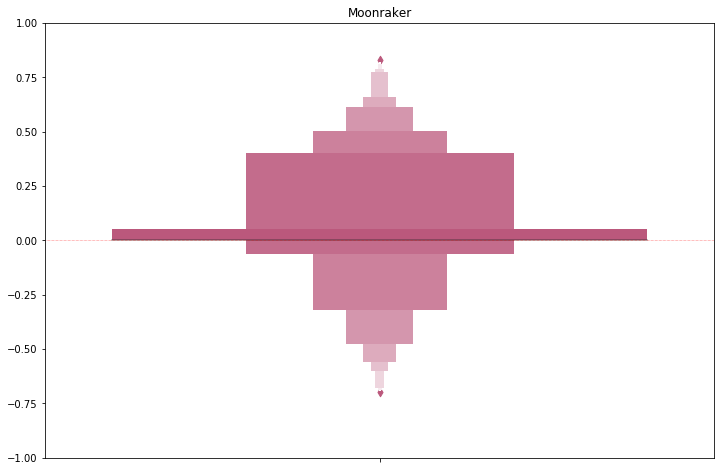

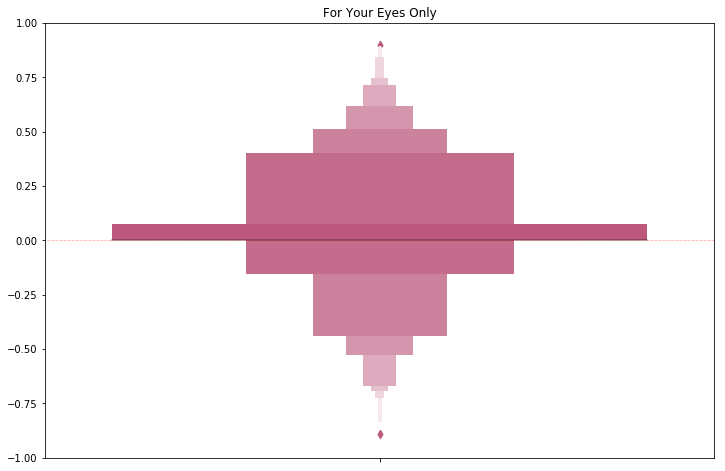

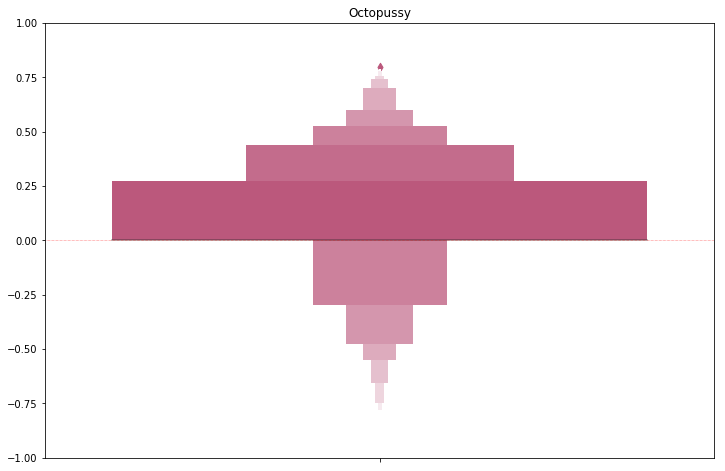

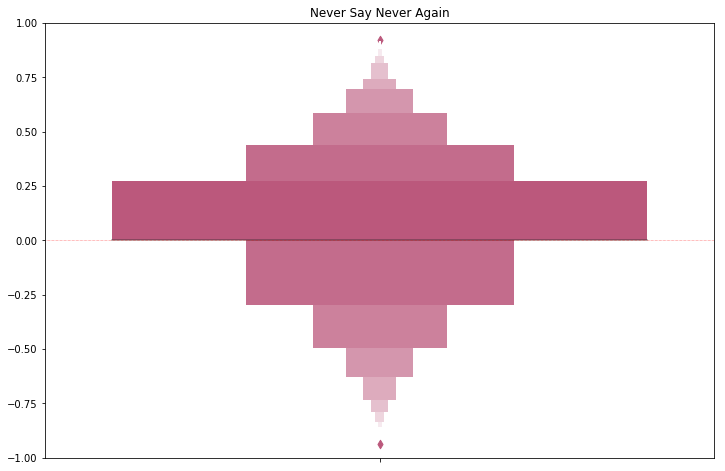

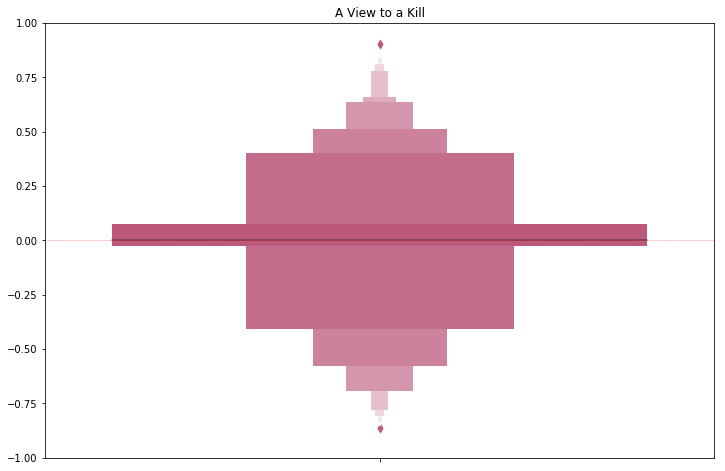

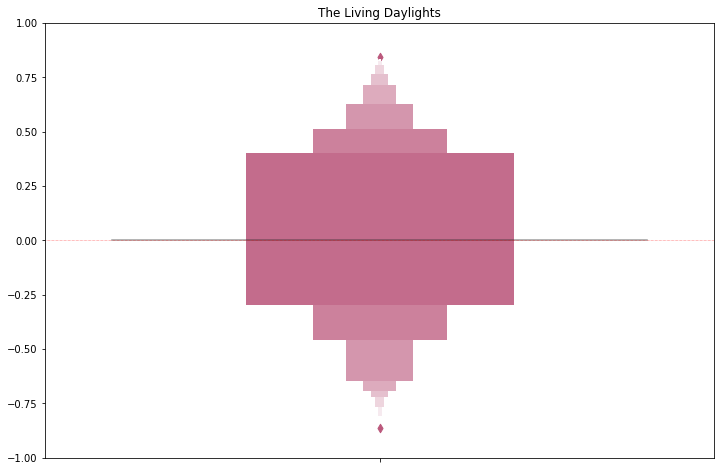

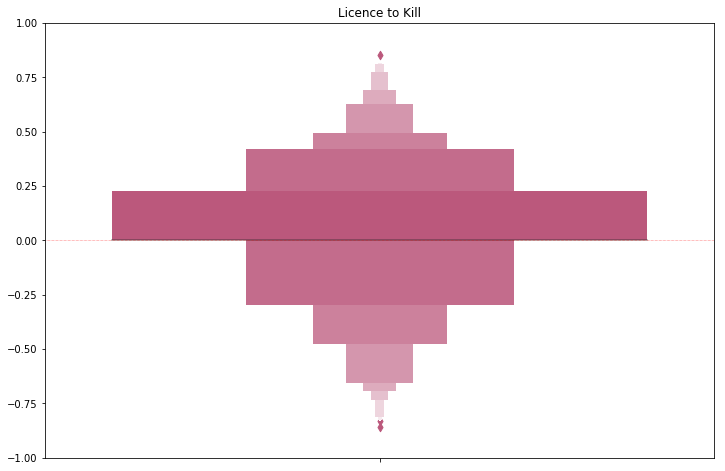

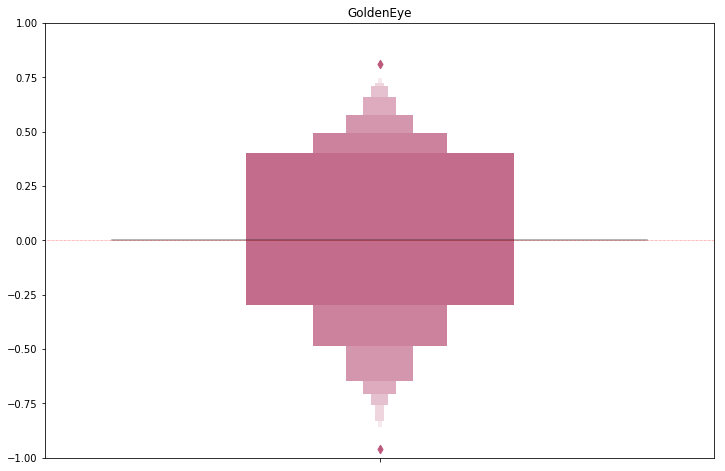

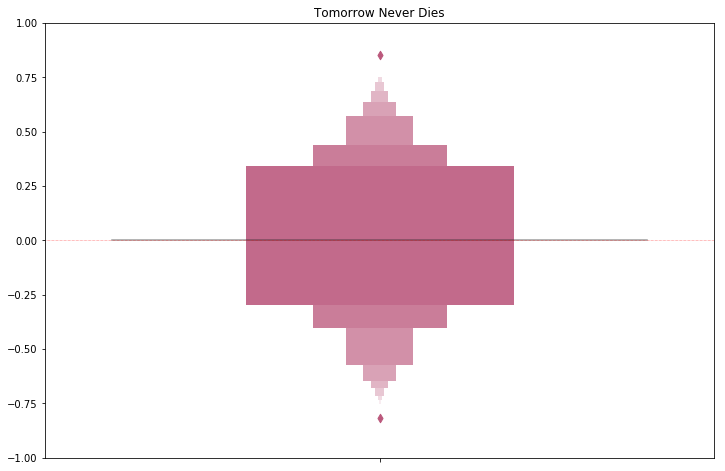

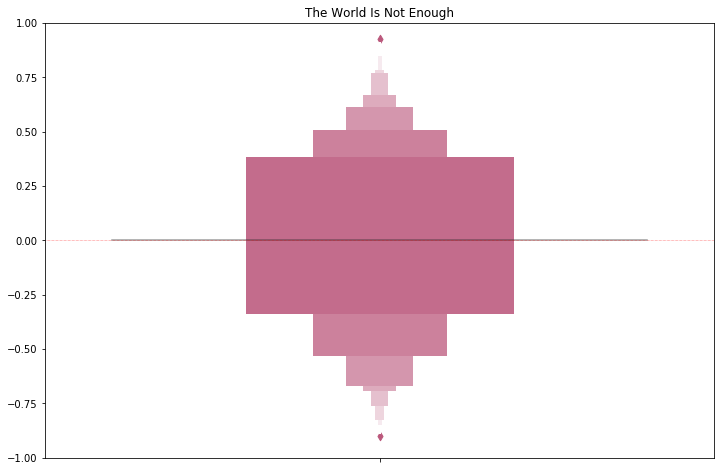

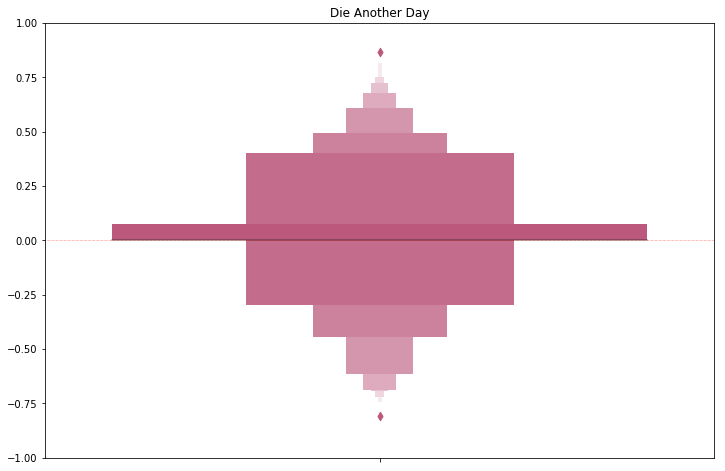

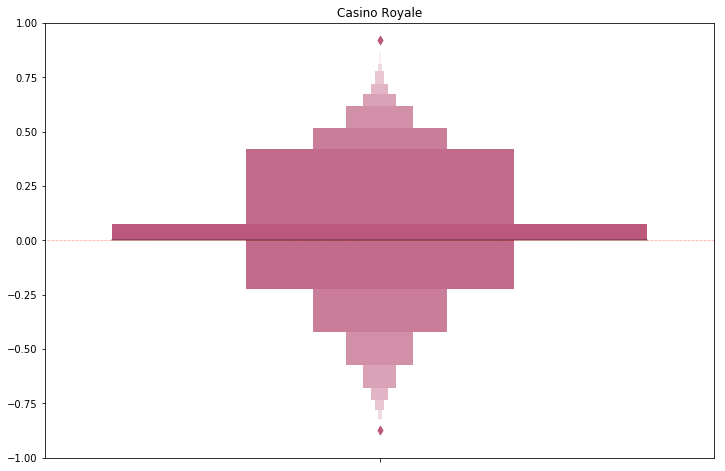

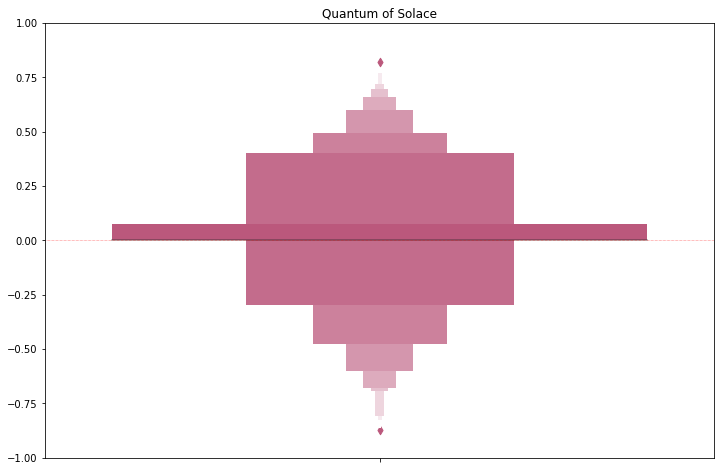

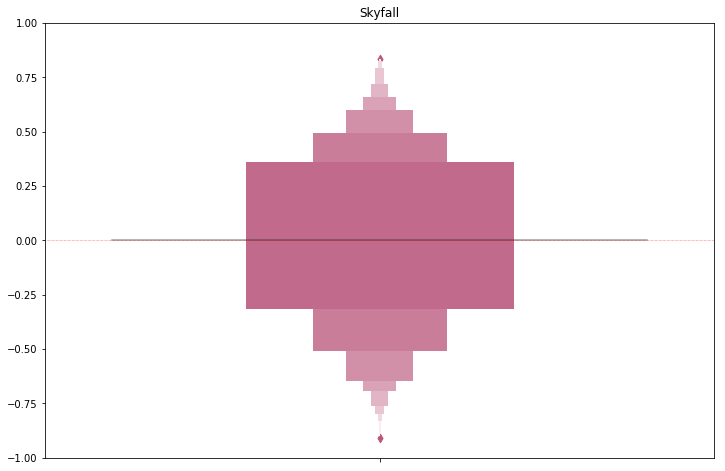

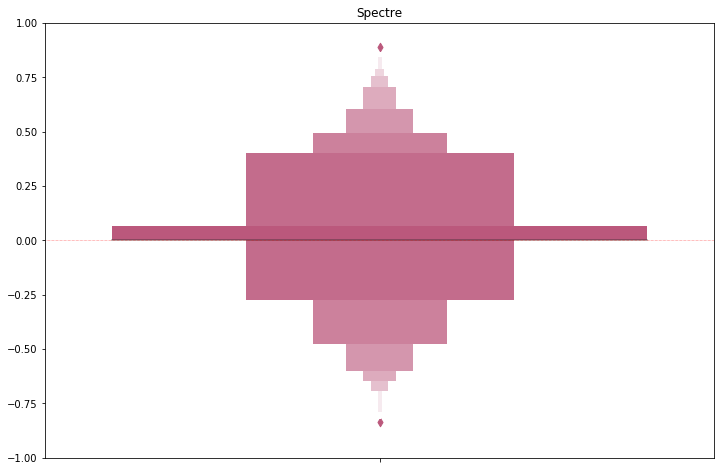

['Dr. No', 'From Russia with Love', 'Goldfinger', 'Thunderball', 'You Only Live Twice', "On Her Majesty's Secret Service", 'Diamonds Are Forever', 'Live and Let Die', 'The Man with the Golden Gun', 'The Spy Who Loved Me', 'Moonraker', 'For Your Eyes Only', 'Octopussy', 'Never Say Never Again', 'A View to a Kill', 'The Living Daylights', 'Licence to Kill', 'GoldenEye', 'Tomorrow Never Dies', 'The World Is Not Enough', 'Die Another Day', 'Casino Royale', 'Quantum of Solace', 'Skyfall', 'Spectre']


In [25]:
bond_srts = ['GoldenEye', 'Goldfinger']
bond_srts = [i for i in df_main.Title]
bond_srts[0] = 'Dr'
bond_dfs = []

for srt in bond_srts:
    srt_test = f'Subtitles/{srt}.en.srt'
    encoding = 'utf-8' 
    temp = srt_to_txt(srt_test, encoding)[1:] #ignore first advertisement 
    bond_dfs.append(temp)    

for title, df in zip(bond_srts, bond_dfs):
    df = pd.DataFrame(df, columns=['Timestamp', 'Dialogue'])
    df['Sentiment'] = df.Dialogue.apply(lambda x: get_sentiment(x))

    # Set rolling means for sentiment
    df['Rol_Sentiment'] = df['Sentiment'].rolling(25, min_periods=5).mean()
    df['Exp_Sentiment'] = df['Sentiment'].expanding(5).mean()
    df.fillna(method='bfill', inplace=True)

    df.index = (pd.to_timedelta(df['Timestamp'].str.strip()))
#     print(df.head(5))

    y = list(df.Sentiment)
    
    #Plotting
    plt.figure(figsize=(12,8))
    
#     plt.plot(df.Rol_Sentiment)
#     plt.plot(df.Exp_Sentiment)
    plt.title(f'{title}')
    
#     g = sns.boxenplot(y=y, data=df, palette='Wistia_r')
    sns.boxenplot(y=y, data=df, palette='plasma')

    plt.axhline(y=0.0, color='r', linestyle=':', linewidth=0.5)
    plt.ylim(top=1, bottom=-1)
    
plt.show();

print(bond_titles)

In [85]:
df

,Timestamp,Dialogue,Sentiment,Rol_Sentiment,Exp_Sentiment
Timestamp,,,,,
00:03:03,00:03:03,Congratulations.,0.5994,0.287460,0.287460
00:03:06,00:03:06,Thank you.,0.3612,0.287460,0.287460
00:03:08,00:03:08,Mr Romales and his friends will be out of busi...,0.4767,0.287460,0.287460
00:03:14,00:03:14,He won't be using heroinflavoured bananas to f...,0.0000,0.287460,0.287460
00:03:18,00:03:18,"Don't go back to your hotel, ser. They'll be w...",0.0000,0.287460,0.287460
00:03:22,00:03:22,There's a plane to Miami in an hour.,0.0000,0.239550,0.239550
00:03:45,00:03:45,"I'll be on it, but first I have some unfinish...",0.0000,0.205329,0.205329
00:03:47,00:03:47,Forgive me.,0.2732,0.213813,0.213813
00:03:49,00:03:49,Why do you always wear that thing?,0.0000,0.190056,0.190056
